# Fetal ECG Extraction from Single-Channel Maternal ECG Using Singular Value Decomposition

> Partha Pratim Kanjilal,* Member, ZEEE, Sarbani Palit, Member, ZEEE, and Goutam Saha

Experiments are based on public dataset ADFECGDB

## Outline of the Extraction Procedure

### 1. Separation of the mECG component from the composite signal
The data are first arranged in the form of a matrix $A$ such that the consecutive maternal ECG cycles occupy the consecutive rows, and the peak maternal component lies in the same column. SVD is performed on $A$, and $A_M = u_1 \sigma_1 (v_1)^T$ is separated from $A$, forming $A_{R1}=A-A_M$

### 2. Extraction of the fECG component
The time series formed from the successive rows of $A_{R1}$ will contain the fECG component along with noise; this series is rearranged into a matrix $B$ such that each row contains one fetal ECG cycle, with the peak value lying in the same column. SVD is performed on $B$, from which the most dominant component $u_1 \sigma_1 (v_1)^T$ is extracted, which will give the desiderd fECG component.

## Mechanism of Fetal ECG Extraction

### Method 1
The most commonly occurring period length for the mECG is considered to be the row lenght ($n$) of the data matrix $A$. The consecutive periods with respect to mECG cycles are aligned into the consecutive rows of $A$, and linearly interpolated data are used for the periods shorter than n. The row length of matrix $B$ is also decided similarly with respect to the fECG cycles. The part of the data in $u_1 \sigma_1 (v_1)^T$ that corresponds to the interpolated data in $A$ or $B$ is eliminated while forming the extracted mECG and the fECG series.

### Method 2
The most likely periodic length (in terms of energy) of the most dominant periodic component present in the signal is considered to be the row lengths of the data matrices $A$ and $B$. The SVR spectrum of the composite maternal ECG signal is used to determine the period length (say $n$) of the mECG component in the composite signal. The periodic segments which are not equal to $n$ in length, are compressed or expanded to the length $n$ as follows.

The data segment $y(1), y(2), ..., y(n^*)$, can be replaced by the set $x(1), x(2), ..., x(n)$ where $n \ne n^*$, using the transformation

$$x(j) = y(j^*) + (y(j^* + 1) - y(j^*))(r_j - j^*)$$

where $r_j = (j - 1)(n^* - 1)/(n - 1) + 1$, and $j^*$ is the integral part of $r_j$. Thus the successive (pseudo-)periods of the composite ECG series $\{y( \cdot )\}$ are converted into data lengths having the same period length $n$, which are now aligned in the rows of the matrix $A$. Appropriate reverse transformation is performed on the data at the time of reconstruction of the extracted mECG series.

The period length of the fECG component is determined from the SVR spectrum of the residual series. The subsequent steps for arranging data into $B$ are the same as above.

### Method 3
Once the $m \times n$ data matrix $A$ is formed, an $m_1 \times n$ ($m_1 \le m$) matrix $\tilde{A}$ is assumed to move over $A$ such that the first row is dropped and a new row is appended for successive locations of the window. $\tilde{A}$ is SV-decomposed, and the last row of $u_1 \sigma_1 (v_1)^T$ is assumed to be the extracted mECG component corresponding to the last row of $\tilde{A}$, which is subtracted from the original composite ECG series. The residual series id arranged into $B$, from which the fECG component is extracted the same way as the mECG component. This scheme is particularly applicable when sufficient amount of data are available.

In [32]:
# --- Imports ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyedflib  # to read EDF files

import neurokit2 as nk  # for ECG preprocessing and segmentation

from scipy.linalg import svd  # for Singular Value Decomposition
from scipy.signal import detrend  # alternative resampling method if needed


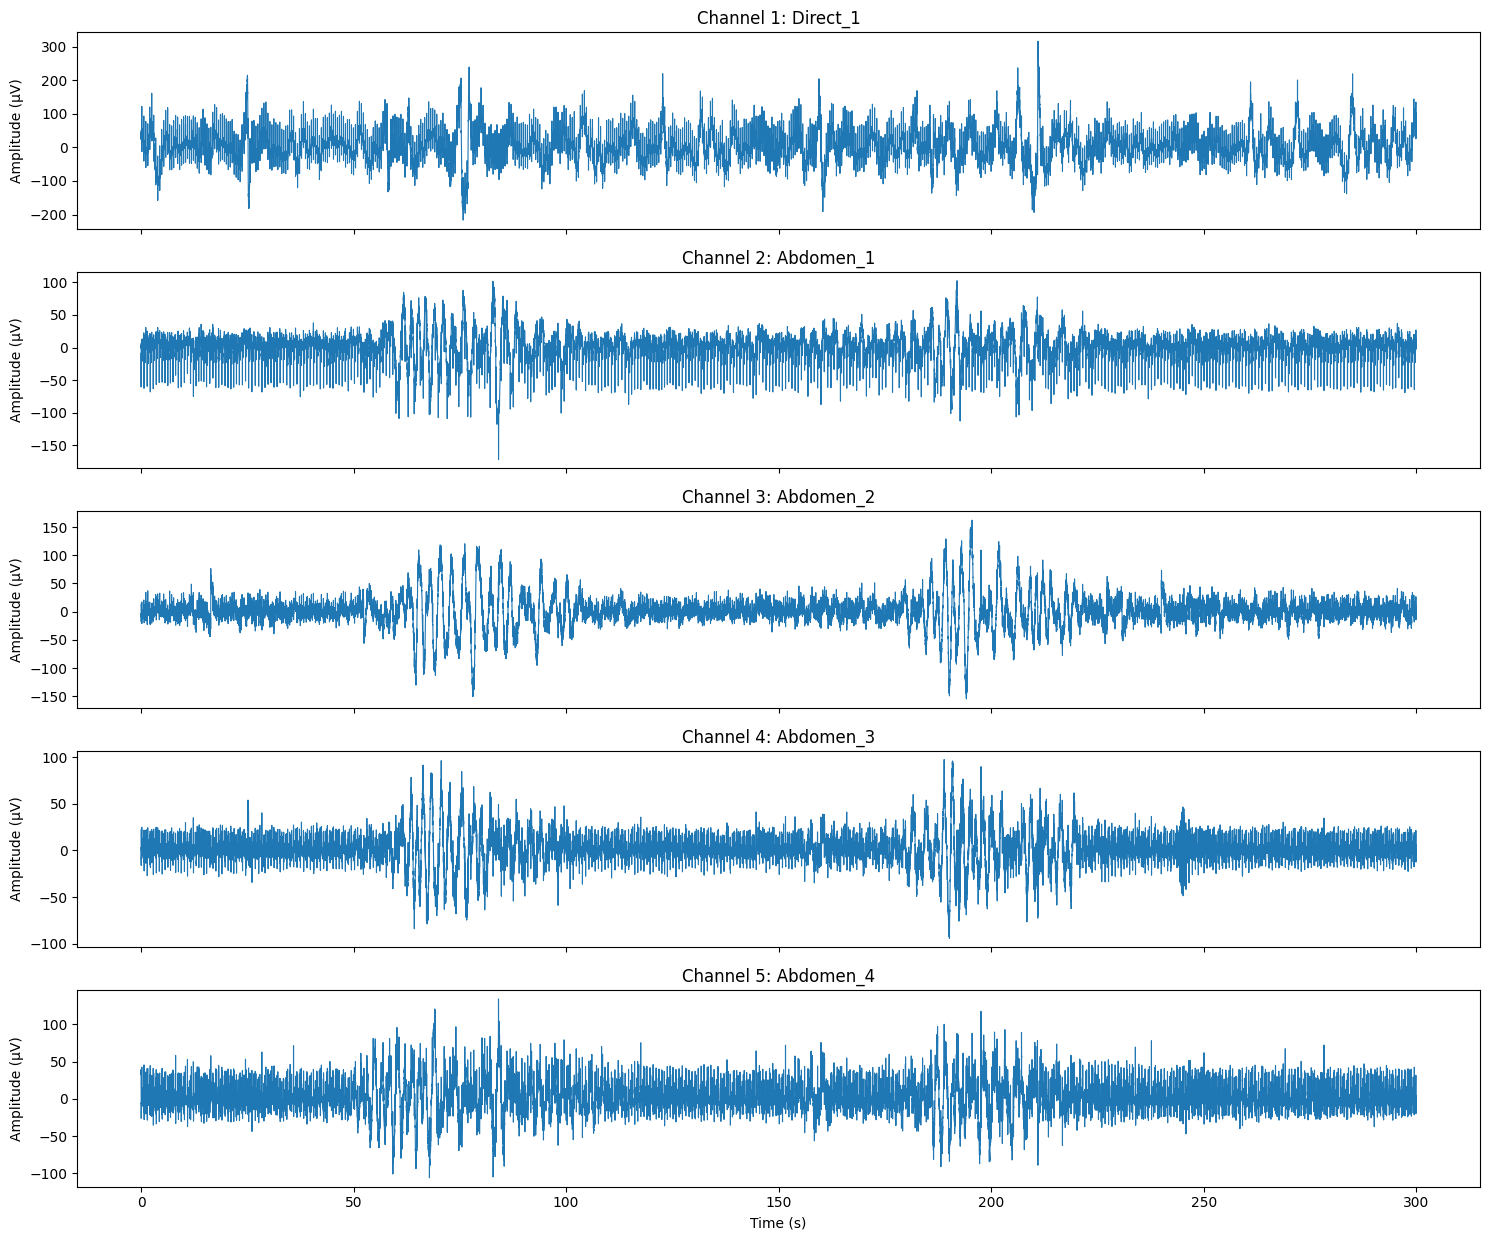

In [33]:
# Load EDF file
edf_path = "../data/raw/r01.edf"
edf = pyedflib.EdfReader(edf_path)

# Get signal info
n_channels = edf.signals_in_file
channel_labels = edf.getSignalLabels()
sampling_rate = edf.getSampleFrequency(0)
signal_duration = edf.getFileDuration()
n_samples = edf.getNSamples()[0]
time_vector = np.linspace(0, signal_duration, n_samples)

# Create subplots
fig, axes = plt.subplots(n_channels, 1, figsize=(15, 2.5 * n_channels), sharex=True)

for i in range(n_channels):
    signal = edf.readSignal(i)
    axes[i].plot(time_vector, signal, linewidth=0.8)
    axes[i].set_title(f"Channel {i+1}: {channel_labels[i]}")
    axes[i].set_ylabel("Amplitude (µV)")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

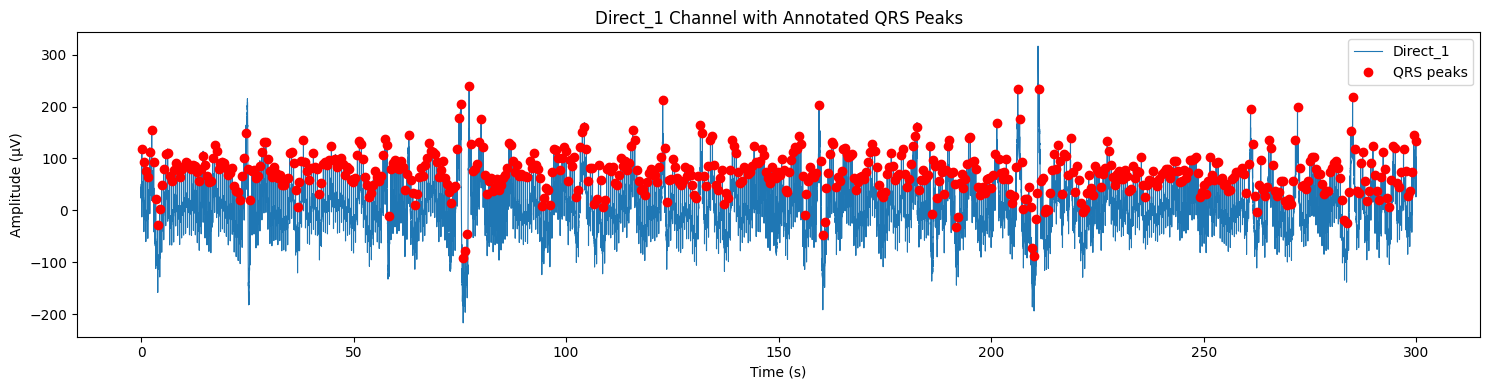

In [34]:
# Read Direct_1 signal only (assumed to be channel 0)
direct_1_signal = edf.readSignal(0)
abdomen_signal = edf.readSignal(1)  # Assuming channel 1 is Abdominal

# Read annotations (assumed to be fetal QRS peaks)
onsets, durations, labels = edf.readAnnotations()
qrs_times = [onsets[i] for i, lbl in enumerate(labels) if lbl.strip().upper() == "QRS"]

# Interpolate signal to get amplitude at annotation times
signal_interp = np.interp(qrs_times, time_vector, direct_1_signal)

# Plot Direct_1 with QRS peaks
plt.figure(figsize=(15, 4))
plt.plot(time_vector, direct_1_signal, label="Direct_1", linewidth=0.8)
plt.plot(qrs_times, signal_interp, 'ro', label="QRS peaks")
plt.title("Direct_1 Channel with Annotated QRS Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.tight_layout()
plt.show()

Estimated optimal maternal ECG period (samples): 104


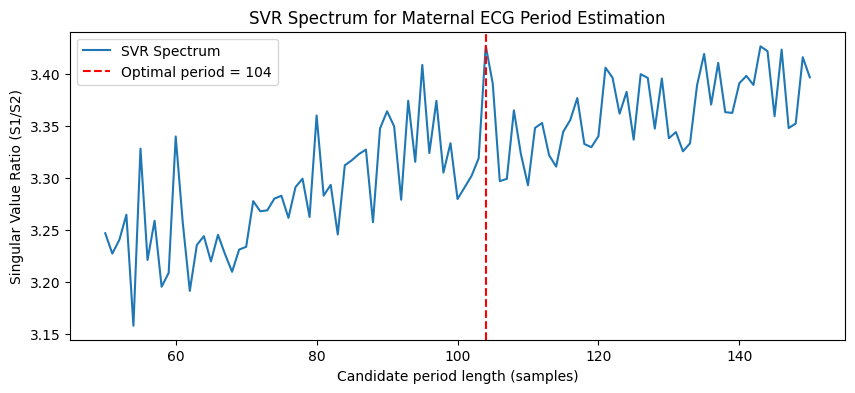

In [35]:
def build_matrix(signal, length):
    n_segments = len(signal) // length
    return np.array([signal[i*length:(i+1)*length] for i in range(n_segments)])

def svr_spectrum(signal, n_min, n_max):
    sv_ratios = []
    candidates = range(n_min, n_max + 1)
    for n in candidates:
        A = build_matrix(signal, n)
        U, S, Vt = np.linalg.svd(A, full_matrices=False)
        sv_ratio = S[0] / S[1] if len(S) > 1 else 0
        sv_ratios.append(sv_ratio)
    return candidates, sv_ratios

# Example usage with Abdomen_1 signal 'abd_signal' (numpy array)
n_min, n_max = 50, 150  # adjust based on expected maternal heart rate
candidates, sv_ratios = svr_spectrum(abdomen_signal, n_min, n_max)

optimal_period = candidates[np.argmax(sv_ratios)]
print(f"Estimated optimal maternal ECG period (samples): {optimal_period}")

plt.figure(figsize=(10,4))
plt.plot(candidates, sv_ratios, label="SVR Spectrum")
plt.axvline(optimal_period, color='r', linestyle='--', label=f"Optimal period = {optimal_period}")
plt.xlabel("Candidate period length (samples)")
plt.ylabel("Singular Value Ratio (S1/S2)")
plt.title("SVR Spectrum for Maternal ECG Period Estimation")
plt.legend()
plt.show()

In [36]:
# Step 1: Detect maternal R-peaks on abdomen_signal (maternal ECG)
cleaned_signal = nk.ecg_clean(abdomen_signal, sampling_rate=1000)
_, rpeaks = nk.ecg_peaks(cleaned_signal, sampling_rate=1000)

maternal_peaks_samples = rpeaks['ECG_R_Peaks']

# Step 2: Define fixed row length for matrix A (from SVR estimate)
period_length = optimal_period  # from your previous SVR results
half_len = period_length // 2

rows = []
for peak in maternal_peaks_samples:
    start_idx = peak - half_len
    end_idx = start_idx + period_length

    # Boundary handling with zero padding
    if start_idx < 0:
        segment = np.pad(abdomen_signal[0:end_idx], (abs(start_idx), 0), mode='constant')
    elif end_idx > len(abdomen_signal):
        segment = np.pad(abdomen_signal[start_idx:], (0, end_idx - len(abdomen_signal)), mode='constant')
    else:
        segment = abdomen_signal[start_idx:end_idx]

    rows.append(segment)

# Step 3: Construct matrix A
A = np.vstack(rows)
print(f"Matrix A shape: {A.shape}")

Matrix A shape: (413, 104)


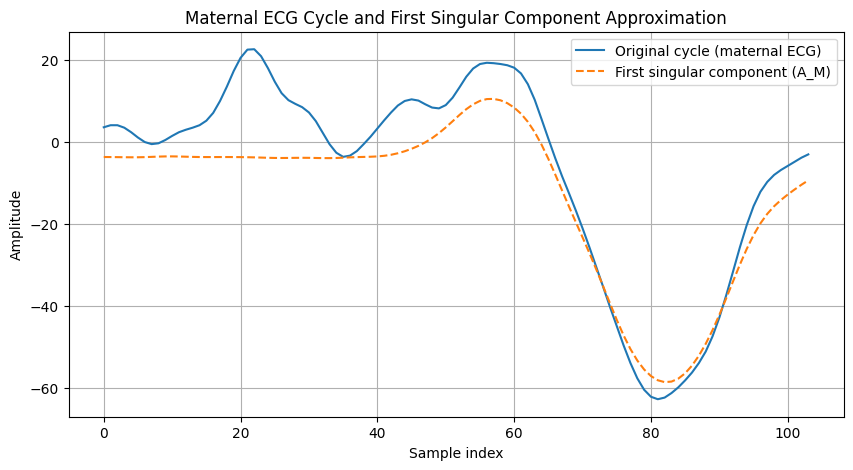

In [37]:
# Perform SVD on A
U, S, VT = np.linalg.svd(A, full_matrices=False)

# Extract first singular component
u1 = U[:, 0].reshape(-1, 1)    # first left singular vector (column)
sigma1 = S[0]                  # first singular value (scalar)
v1 = VT[0, :].reshape(1, -1)   # first right singular vector (row)

# Reconstruct the rank-1 approximation: A_M = u1 * sigma1 * v1
A_M = sigma1 * np.dot(u1, v1)

# Plot one cycle of A (row) and corresponding row of A_M (approximation)
cycle_idx = 0  # choose which cycle to plot
plt.figure(figsize=(10, 5))
plt.plot(A[cycle_idx, :], label="Original cycle (maternal ECG)")
plt.plot(A_M[cycle_idx, :], label="First singular component (A_M)", linestyle='--')
plt.title("Maternal ECG Cycle and First Singular Component Approximation")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

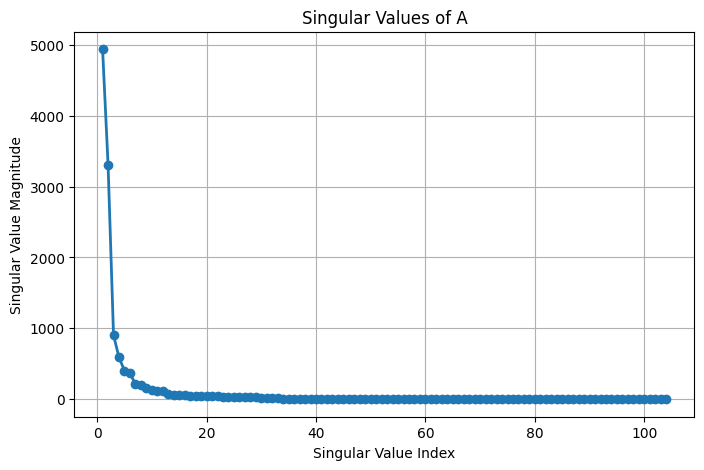

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(S) + 1), S, 'o-', linewidth=2)
plt.title("Singular Values of A")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value Magnitude")
plt.grid(True)
plt.show()

Estimated optimal period length from A_M: 39 samples


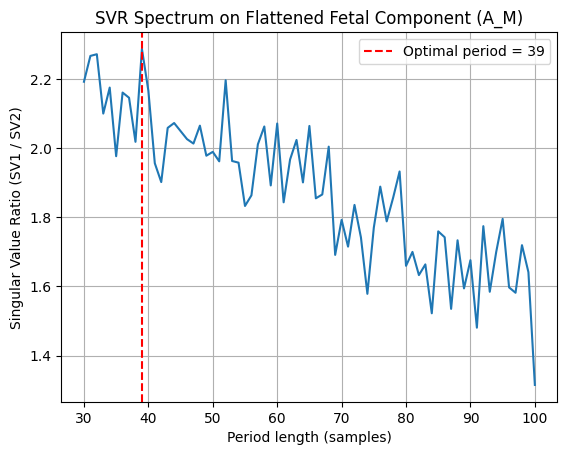

In [39]:
# Flatten A_M (maternal component matrix)
A_R = A - A_M
A_R_flatten = A_R.flatten()

# Define min and max period length to test (adjust as needed)
n_min = 30
n_max = 100

# Compute SVR spectrum on flattened maternal component A_M
candidates, sv_ratios = svr_spectrum(A_R_flatten, n_min, n_max)

# Find optimal period length maximizing singular value ratio
optimal_period_index = np.argmax(sv_ratios)
optimal_period = candidates[optimal_period_index]

print(f"Estimated optimal period length from A_M: {optimal_period} samples")

# Optional: plot SVR spectrum
import matplotlib.pyplot as plt
plt.plot(candidates, sv_ratios)
plt.axvline(optimal_period, color='red', linestyle='--', label=f'Optimal period = {optimal_period}')
plt.xlabel('Period length (samples)')
plt.ylabel('Singular Value Ratio (SV1 / SV2)')
plt.title('SVR Spectrum on Flattened Fetal Component (A_M)')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
# Flatten the residual matrix A_R into a 1D signal
residual_signal = A_R.flatten()

# Define the fetal ECG period length
fetal_period = optimal_period

# Function to build matrix with given row length
def build_matrix(signal, length):
    n_segments = len(signal) // length
    return np.array([signal[i*length:(i+1)*length] for i in range(n_segments)])

# Build B_F matrix with rows length = fetal_period
B_F = build_matrix(residual_signal, fetal_period)

print(f"B_F shape: {B_F.shape}")

B_F shape: (1101, 39)


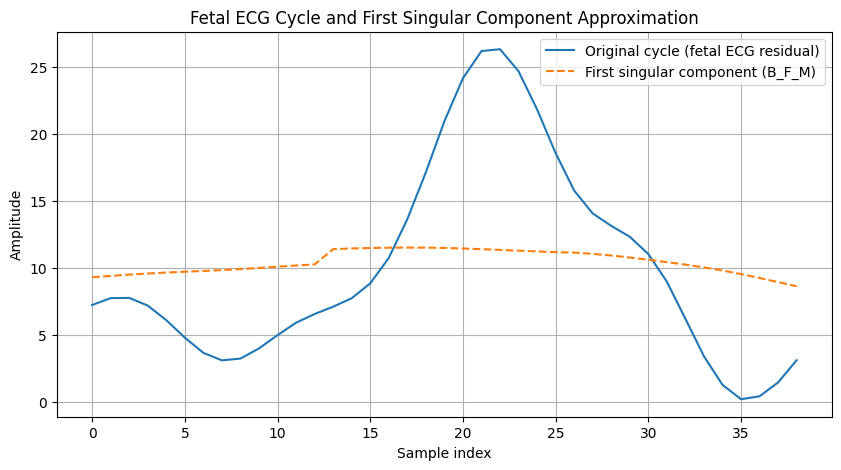

In [41]:
# Perform SVD on B_F
U_B, S_B, VT_B = np.linalg.svd(B_F, full_matrices=False)

# Extract first singular component
u1_B = U_B[:, 0].reshape(-1, 1)      # first left singular vector (column)
sigma1_B = S_B[0]                    # first singular value (scalar)
v1_B = VT_B[0, :].reshape(1, -1)    # first right singular vector (row)

# Reconstruct the rank-1 approximation: B_F_M = u1 * sigma1 * v1
B_F_M = sigma1_B * np.dot(u1_B, v1_B)

# Plot one cycle of B_F (row) and corresponding row of B_F_M (approximation)
cycle_idx = 0  # choose which cycle to plot
plt.figure(figsize=(10, 5))
plt.plot(B_F[cycle_idx, :], label="Original cycle (fetal ECG residual)")
plt.plot(B_F_M[cycle_idx, :], label="First singular component (B_F_M)", linestyle='--')
plt.title("Fetal ECG Cycle and First Singular Component Approximation")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


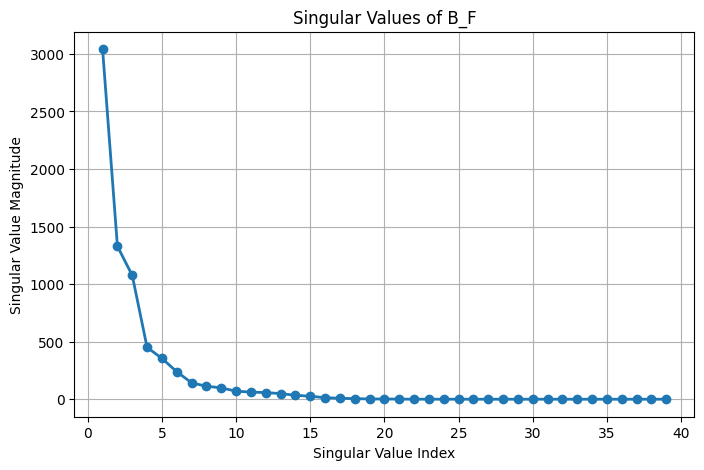

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(S_B) + 1), S_B, 'o-', linewidth=2)
plt.title("Singular Values of B_F")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value Magnitude")
plt.grid(True)
plt.show()

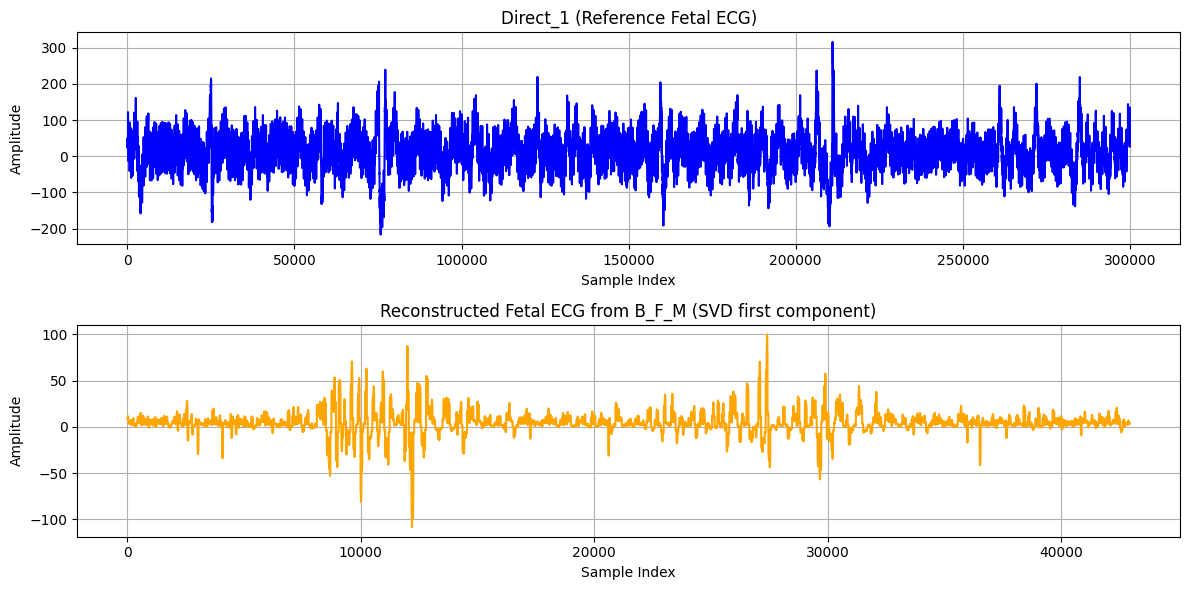

In [43]:
plt.figure(figsize=(12, 6))

# Plot Direct_1 (fECG reference)
plt.subplot(2, 1, 1)
plt.plot(direct_1_signal, color='blue')
plt.title('Direct_1 (Reference Fetal ECG)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)

# Flatten B_F_M for continuous waveform plotting
B_F_M_flat = B_F_M.flatten()

plt.subplot(2, 1, 2)
plt.plot(B_F_M_flat, color='orange')
plt.title('Reconstructed Fetal ECG from B_F_M (SVD first component)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()


## Load data

In [44]:
# Load EDF file
edf_path = "../data/raw/r01.edf"
edf = pyedflib.EdfReader(edf_path)

# Get metadata
n_channels = edf.signals_in_file
channel_labels = edf.getSignalLabels()
signal_freq = edf.getSampleFrequency(0)

print("Channels:", channel_labels)
print("Sampling frequency:", signal_freq)

signals = [edf.readSignal(i) for i in range(n_channels)]
df = pd.DataFrame({label: signal for label, signal in zip(channel_labels, signals)})

edf._close()

channels = ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']

plt.figure(figsize=(15, 10))

for i, channel in enumerate(channels):
    # cleaned = nk.ecg_clean(df[channel], sampling_rate=signal_freq)
    plt.subplot(5, 1, i + 1)
    plt.plot(df[channel], linewidth=0.8) # try also with cleaned
    plt.title(f"{channel} (Original)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")

plt.suptitle("Abdominal ECG Channels from r01.edf (Original)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


OSError: ../data/raw/r01.edf: file has already been opened

In [ ]:
import numpy as np

def construct_A_matrix(signal, qrs_onsets_sec, fs, pre_R_samples, post_R_samples):
    """
    Construct matrix A where each row is one ECG cycle aligned on the QRS peak.

    Parameters:
    - signal: 1D numpy array, raw or cleaned ECG signal
    - qrs_onsets_sec: list or array of QRS onset times in seconds (manual annotations)
    - fs: sampling frequency (Hz)
    - pre_R_samples: number of samples before QRS peak in each window
    - post_R_samples: number of samples after QRS peak in each window

    Returns:
    - A: 2D numpy array of shape (num_cycles, pre_R_samples + post_R_samples + 1)
    """
    qrs_samples = [int(t * fs) for t in qrs_onsets_sec]
    window_length = pre_R_samples + post_R_samples + 1

    # Filter QRS to ensure window fits within signal boundaries
    valid_qrs = [idx for idx in qrs_samples if (idx - pre_R_samples >= 0) and (idx + post_R_samples < len(signal))]

    # Extract aligned cycles
    A = np.array([
        signal[idx - pre_R_samples : idx + post_R_samples + 1]
        for idx in valid_qrs
    ])

    return A

# Example usage:

# Parameters
fs = 1000  # sampling frequency in Hz
pre_R = 150  # samples before QRS
post_R = 250  # samples after QRS

# signal: your raw or cleaned ECG signal, e.g. from 'Abdomen_1' channel
signal = df['Abdomen_1'].values  # or any numpy array

# qrs_onsets_sec: manual annotation times (from EDF or your annotations)
qrs_onsets_sec = annotations[0]  # example, list/array of QRS times in seconds

# Construct matrix A
A = construct_A_matrix(signal, qrs_onsets_sec, fs, pre_R, post_R)

print("Matrix A shape (beats x samples):", A.shape)


NameError: name 'annotations' is not defined

In [ ]:
import numpy as np
import pandas as pd
import pyedflib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.linalg import svd

# 1. Build matrix A of maternal cycles from annotated maternal QRS times
def build_maternal_matrix(signal, maternal_qrs_times, fs, cycle_length_samples):
    # cycle_length_samples: window length around each maternal peak (e.g. pre + post samples)
    n_cycles = len(maternal_qrs_times)
    A = np.zeros((n_cycles, cycle_length_samples))
    
    pre_samples = cycle_length_samples // 2
    post_samples = cycle_length_samples - pre_samples
    
    for i, peak_time in enumerate(maternal_qrs_times):
        center_idx = int(peak_time * fs)
        start = center_idx - pre_samples
        end = start + cycle_length_samples
        segment = np.zeros(cycle_length_samples)
        if start >= 0 and end <= len(signal):
            segment[:] = signal[start:end]
        else:
            # For incomplete segments, zero-pad or use interpolation if needed
            segment_len = end - start
            actual_start = max(start, 0)
            actual_end = min(end, len(signal))
            segment_slice = signal[actual_start:actual_end]
            segment[:len(segment_slice)] = segment_slice
        A[i, :] = segment
    return A

# 2. Perform SVD and extract dominant maternal component
def extract_dominant_component(A):
    U, S, VT = svd(A, full_matrices=False)
    A_M = np.outer(U[:, 0] * S[0], VT[0, :])
    A_R1 = A - A_M
    return A_M, A_R1

# 3. Compute SVR spectrum to find fetal cycle length
def compute_svr_spectrum(A_R1, min_row_len, max_row_len, m1):
    """
    Compute SVR spectrum of sigma_1 / sigma_2 over varying row lengths.
    - A_R1: residual matrix (maternal removed)
    - min_row_len, max_row_len: search range for fetal cycle length (samples)
    - m1: moving window length over rows of A_R1 to compute median SVR
    Returns: dict {row_len: median_svr}
    """
    svr_spectrum = {}
    n_rows, n_cols = A_R1.shape
    
    for n in range(min_row_len, max_row_len + 1):
        if n > n_cols:
            break  # Cannot have row length > number of columns
        
        num_windows = n_rows - m1 + 1
        sv_ratios = []
        
        for start_row in range(num_windows):
            window = A_R1[start_row:start_row+m1, :n]
            U, S, VT = svd(window, full_matrices=False)
            if len(S) > 1 and S[1] != 0:
                sv_ratios.append(S[0] / S[1])
            else:
                sv_ratios.append(0)
        
        svr_spectrum[n] = np.median(sv_ratios)
    return svr_spectrum

# 4. Build matrix B for fetal cycles from residual matrix A_R1, using fetal cycle length n (estimated)
def build_fetal_matrix(A_R1, fetal_cycle_length):
    # Assuming fetal cycles aligned by moving windows of length fetal_cycle_length
    n_rows, n_cols = A_R1.shape
    m2 = n_rows - fetal_cycle_length + 1
    B = np.zeros((m2, fetal_cycle_length))
    for i in range(m2):
        B[i, :] = A_R1[i, :fetal_cycle_length]
    return B

# 5. Perform SVD on B to extract dominant fetal component
def extract_fetal_component(B):
    U, S, VT = svd(B, full_matrices=False)
    B_F = np.outer(U[:, 0] * S[0], VT[0, :])
    return B_F

# === Usage example ===

# Load your data & maternal annotations first (not shown here)
# signal: numpy array of abdominal signal (e.g., Direct_1)
# maternal_qrs_times: list or array of maternal QRS times in seconds
# fs: sampling frequency

# Step 1: build maternal matrix A
maternal_cycle_length = int(0.8 * fs)  # example 0.8s maternal cycle window length
A = build_maternal_matrix(signal, maternal_qrs_times, fs, maternal_cycle_length)

# Step 2: extract dominant maternal component and residual
A_M, A_R1 = extract_dominant_component(A)

# Step 3: compute SVR spectrum to find fetal cycle length
svr_spec = compute_svr_spectrum(A_R1, min_row_len=int(0.3*fs), max_row_len=int(0.6*fs), m1=10)

# Pick fetal cycle length n corresponding to max SVR value
best_n = max(svr_spec, key=svr_spec.get)
print(f"Estimated fetal cycle length (samples): {best_n}")

# Step 4: build fetal matrix B from residual A_R1
B = build_fetal_matrix(A_R1, best_n)

# Step 5: extract dominant fetal component
B_F = extract_fetal_component(B)

# Further steps: reconstruct fetal ECG, plot, etc.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have:
# signal: original Direct_1 abdominal signal (1D numpy array)
# fs: sampling frequency in Hz
# maternal_qrs_times: list or numpy array of maternal QRS times in seconds
# A_M: maternal component matrix from build_maternal_matrix + SVD step (shape: n_cycles x cycle_length)
# B_F: fetal component matrix (shape: n_cycles_fetal x fetal_cycle_length)

# 1. Reconstruct maternal ECG signal from A_M matrix back to original signal length
def reconstruct_signal_from_cycles(cycles_matrix, qrs_times, fs, signal_length):
    reconstructed = np.zeros(signal_length)
    counts = np.zeros(signal_length)  # To average overlapping windows
    
    cycle_length = cycles_matrix.shape[1]
    pre_samples = cycle_length // 2
    
    for i, peak_time in enumerate(qrs_times):
        center_idx = int(peak_time * fs)
        start = center_idx - pre_samples
        end = start + cycle_length
        
        if start < 0 or end > signal_length:
            continue  # skip edges
        
        reconstructed[start:end] += cycles_matrix[i, :]
        counts[start:end] += 1
    
    # Avoid division by zero
    counts[counts == 0] = 1
    reconstructed /= counts
    
    return reconstructed

# 2. For fetal ECG reconstruction: since fetal QRS not annotated, reconstruct by overlap-adding B_F rows
def reconstruct_fetal_signal(B_F, length_estimate):
    # Overlap-add fetal cycles
    reconstructed = np.zeros(length_estimate)
    counts = np.zeros(length_estimate)
    
    cycle_length = B_F.shape[1]
    step = cycle_length // 2  # assuming 50% overlap; adjust as needed
    pos = 0
    
    for i in range(B_F.shape[0]):
        end = pos + cycle_length
        if end > length_estimate:
            break
        reconstructed[pos:end] += B_F[i, :]
        counts[pos:end] += 1
        pos += step
    
    counts[counts == 0] = 1
    reconstructed /= counts
    return reconstructed

# Reconstruct maternal ECG
signal_length = len(signal)
mECG_reconstructed = reconstruct_signal_from_cycles(A_M, maternal_qrs_times, fs, signal_length)

# Reconstruct fetal ECG
# Estimate length for fetal reconstruction (can use original signal length or shorter)
fetal_signal_length = signal_length  # or smaller if you want
fECG_reconstructed = reconstruct_fetal_signal(B_F, fetal_signal_length)

# Plot all three
time = np.arange(signal_length) / fs

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(time, signal, color='black')
plt.title('Original Abdominal Signal (Direct_1)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(time, mECG_reconstructed, color='blue')
plt.title('Extracted Maternal ECG (mECG)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(time, fECG_reconstructed, color='red')
plt.title('Extracted Fetal ECG (fECG)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


## Method 1

### Extract mECG

> A maternal heart rate (mHR), measured by an electrocardiogram (ECG), generally falls between 60 and 100 bpm at rest. 

In [ ]:
# Let's perform the experiment on Abdomen_1 channel
# ecg_segment segments an ECG signal into single heartbeats
raw_signal = df['Abdomen_1'].values
cleaned_signal = nk.ecg_clean(raw_signal, sampling_rate=1000)
qrs_epochs = nk.ecg_segment(cleaned_signal, rpeaks=None, sampling_rate=1000, show=True)

A = pd.DataFrame({
    beat_id: epoch["Signal"].values
    for beat_id, epoch in qrs_epochs.items()
}).T  # Transpose to shape (n_beats, n_samples)

print("(#beats, #samples) =", A.shape)

In [ ]:
# Plot first 5 QRS segments
plt.figure(figsize=(12, 6))

for i in range(5):
    plt.plot(A.iloc[i], label=f'Beat {i+1}', alpha=0.8)

plt.title("First 5 QRS Segments from Abdomen_1")
plt.xlabel("Samples (centered around R-peak)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

if A.isna().any().any() or np.isinf(A.values).any():
    A = A.fillna(0)
    A = A.replace([np.inf, -np.inf], 0)
A = A.values  # Convert to NumPy array before SVD


In [ ]:
U, S, VT = np.linalg.svd(A, full_matrices=False)
# Extract the dominant maternal component (rank-1 approximation)
A_M = np.outer(U[:, 0], VT[0, :]) * S[0]
# Compute the residual matrix by subtracting maternal component from A
A_residual = A - A_M

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(S, marker='o')
plt.title("Singular Values of Matrix A (Maternal ECG Cycles)")
plt.xlabel("Component Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()


### Extract fECG

> The normal fetal heart rate (FHR) typically ranges from 110 to 160 beats per minute (bpm).

In [ ]:
# Now we flatten the residual signal and we do again the segmentation
residual_signal = A_residual.flatten()
cleaned_signal = nk.ecg_clean(residual_signal, sampling_rate=1000)
fetal_qrs_epochs = nk.ecg_segment(cleaned_signal, rpeaks=None, sampling_rate=1000, show=True)

B = pd.DataFrame({
    beat_id: epoch["Signal"].values
    for beat_id, epoch in fetal_qrs_epochs.items()
}).T.values

if np.isnan(B).any() or np.isinf(B).any():
    B = np.nan_to_num(B)

U_B, S_B, VT_B = np.linalg.svd(B, full_matrices=False)
# Dominant fetal ECG component (rank-1 approximation)
B_F = np.outer(U_B[:, 0], VT_B[0, :]) * S_B[0]
# Compute the residual matrix by subtracting fetal component from residual
B_residual = B - B_F

In [ ]:
# Flatten extracted fetal ECG cycles
fecg_flat = B_F.flatten()

# Extract corresponding segment from df['Direct_1']
direct1_signal = df['Direct_1'].values
direct1_segment = direct1_signal[:len(fecg_flat)]

plt.figure(figsize=(15, 8))

# Plot Extracted Fetal ECG
plt.subplot(2, 1, 1)
plt.plot(fecg_flat, color='red', linewidth=0.8)
plt.title("Extracted Fetal ECG (B_F)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Plot Reference Fetal ECG (Direct_1)
plt.subplot(2, 1, 2)
plt.plot(direct1_segment, color='blue', alpha=0.7, linewidth=0.8)
plt.title("Reference Fetal ECG (Direct_1)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.suptitle("Comparison of Extracted and Reference Fetal ECG", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Extract another ECG from the last residual matrix

In [ ]:
# Again, we flatten the residual signal and we do the segmentation
residual_signal = B_residual.flatten()
cleaned_signal = nk.ecg_clean(residual_signal, sampling_rate=1000)
fetal_qrs_epochs = nk.ecg_segment(cleaned_signal, rpeaks=None, sampling_rate=1000, show=True)

B = pd.DataFrame({
    beat_id: epoch["Signal"].values
    for beat_id, epoch in fetal_qrs_epochs.items()
}).T.values

if np.isnan(B).any() or np.isinf(B).any():
    B = np.nan_to_num(B)

U_B, S_B, VT_B = np.linalg.svd(B, full_matrices=False)
# Dominant secondary fetal ECG component (rank-1 approximation)
B_F2 = np.outer(U_B[:, 0], VT_B[0, :]) * S_B[0]

In [ ]:
# Flatten extracted fetal ECG cycles
fecg_flat = B_F2.flatten()

# Extract corresponding segment from df['Direct_1']
direct1_signal = df['Direct_1'].values
direct1_segment = direct1_signal[:len(fecg_flat)]

plt.figure(figsize=(15, 8))

# Extracted Fetal ECG (B_F)
plt.subplot(2, 1, 1)
plt.plot(fecg_flat, label='Extracted Fetal ECG (B_F)', color='red', linewidth=0.8)
plt.title('Extracted Fetal ECG (B_F)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

# Reference Fetal ECG (Direct_1)
plt.subplot(2, 1, 2)
plt.plot(direct1_segment, label='Reference Fetal ECG (Direct_1)', color='blue', alpha=0.7, linewidth=0.8)
plt.title('Reference Fetal ECG (Direct_1)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.suptitle("Comparison of Extracted and Reference Fetal ECG Signals", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Method 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
from scipy.interpolate import interp1d

In [ ]:
def highpass_filter_bidirectional(signal, a=0.88):
    """
    Apply a bidirectional high-pass filter with a pole at `a`.
    Equivalent to F(z) = (1 - a) / (1 - a z^-1)
    """
    b = [1 - a]
    a_coeffs = [1, -a]
    return filtfilt(b, a_coeffs, signal)


def compute_svr_spectrum(signal, max_period=300):
    """
    Compute the SVR spectrum to estimate dominant period.
    """
    energy_ratios = []
    period_range = range(20, max_period)
    for n in period_range:
        m = len(signal) // n
        if m < 2:
            break
        matrix = signal[:m * n].reshape((m, n))
        _, S, _ = np.linalg.svd(matrix, full_matrices=False)
        ratio = S[0] / S.sum()
        energy_ratios.append(ratio)

    best_n = period_range[np.argmax(energy_ratios)]

    plt.figure(figsize=(12, 4))
    plt.plot(period_range, energy_ratios)
    plt.title("SVR Spectrum")
    plt.xlabel("Period Length (n)")
    plt.ylabel("Singular Value Ratio")
    plt.grid(True)
    plt.show()

    return best_n


def resample_period(y, n_target):
    """
    Resample segment y to length n_target using the transformation in the paper.
    """
    n_star = len(y)
    x = np.zeros(n_target)
    for j in range(n_target):
        r_j = (j) * (n_star - 1) / (n_target - 1) + 1
        j_star = int(np.floor(r_j)) - 1
        delta = r_j - (j_star + 1)
        if j_star + 1 < n_star:
            x[j] = y[j_star] + (y[j_star + 1] - y[j_star]) * delta
        else:
            x[j] = y[j_star]  # edge case
    return x


def build_matrix(signal, period):
    """
    Build matrix with resampled segments of length `period`.
    """
    segments = []
    i = 0
    while i + 20 < len(signal):  # need at least 20 samples per segment
        # Find next segment (e.g., 1.5*period window for alignment)
        end = min(i + int(1.5 * period), len(signal))
        seg = signal[i:end]
        if len(seg) >= 10:
            seg_resampled = resample_period(seg, period)
            segments.append(seg_resampled)
        i += period

    return np.vstack(segments)


In [ ]:
# Filter signals to remove low-frequency drift
composite_filtered = highpass_filter_bidirectional(raw_signal)
residual_filtered = highpass_filter_bidirectional(residual_signal)

# Estimate periods
n_mecg = compute_svr_spectrum(composite_filtered)
n_fecg = compute_svr_spectrum(residual_filtered)

# Build matrices
A = build_matrix(composite_filtered, n_mecg)
B = build_matrix(residual_filtered, n_fecg)

# SVD of A and B
U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=False)
U_B, S_B, VT_B = np.linalg.svd(B, full_matrices=False)

A_M = np.outer(U_A[:, 0], VT_A[0, :]) * S_A[0]
B_F = np.outer(U_B[:, 0], VT_B[0, :]) * S_B[0]


In [ ]:
# Flatten A_M and B_F
A_M_flat = A_M.flatten()
B_F_flat = B_F.flatten()

# Clean Direct_1 and match length
direct1_signal = df["Direct_1"].values
direct1_cleaned = nk.ecg_clean(direct1_signal, sampling_rate=signal_freq)
direct1_segment = direct1_cleaned[:len(B_F_flat)]

# Plot in three subplots
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(A_M_flat[:len(B_F_flat)], color='green')
plt.title("Extracted Maternal ECG (A_M)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.plot(B_F_flat, color='red')
plt.title("Extracted Fetal ECG (B_F)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.plot(direct1_segment, color='blue')
plt.title("Reference Fetal ECG (Direct_1)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

## Method 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sliding_window_svd_extraction(A, window_size):
    """
    Apply Method 3: Sliding window SVD over matrix A (for mECG).
    Returns the extracted mECG signal and the residual (used for fECG).
    """
    m, n = A.shape
    mecg_rows = []

    # Sliding window over rows of A
    for i in range(m - window_size + 1):
        A_tilde = A[i:i+window_size, :]

        # SVD of the window
        U, S, VT = np.linalg.svd(A_tilde, full_matrices=False)

        # Rank-1 approximation
        A_approx = np.outer(U[:, 0], VT[0, :]) * S[0]

        # Last row is the estimated mECG
        mecg_rows.append(A_approx[-1, :])

    # Reconstruct the flattened mECG signal
    mecg_flat = np.array(mecg_rows).flatten()

    # Flatten the original A to match the same length
    original_flat = A[window_size-1:].reshape(-1, n).flatten()

    # Residual signal for fetal ECG extraction
    residual_flat = original_flat - mecg_flat

    return mecg_flat, residual_flat


In [ ]:
def extract_fetal_from_residual(residual_flat, period_length):
    """
    Arrange residual into B and extract fetal ECG using SVD.
    """
    # Segment into rows of length `period_length`
    segments = len(residual_flat) // period_length
    B = residual_flat[:segments * period_length].reshape(segments, period_length)

    # SVD of B
    U, S, VT = np.linalg.svd(B, full_matrices=False)
    B_F = np.outer(U[:, 0], VT[0, :]) * S[0]

    # Flatten the fetal ECG
    fecg_flat = B_F.flatten()
    return fecg_flat


In [ ]:
import matplotlib.pyplot as plt

def plot_results_subplots(mecg_flat, fecg_flat, reference_signal):
    min_len = min(len(mecg_flat), len(fecg_flat), len(reference_signal))
    mecg_flat = mecg_flat[:min_len]
    fecg_flat = fecg_flat[:min_len]
    reference_signal = reference_signal[:min_len]

    plt.figure(figsize=(15, 9))

    # Maternal ECG
    plt.subplot(3, 1, 1)
    plt.plot(mecg_flat, color='blue')
    plt.title("Extracted Maternal ECG (A_M)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")

    # Reference Fetal ECG (Direct_1)
    plt.subplot(3, 1, 2)
    plt.plot(reference_signal, color='green')
    plt.title("Reference Fetal ECG (Direct_1)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")

    # Extracted Fetal ECG
    plt.subplot(3, 1, 3)
    plt.plot(fecg_flat, color='red')
    plt.title("Extracted Fetal ECG (B_F)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()


In [ ]:
# Assume you have matrix A (cleaned + period-aligned abdominal signal)
window_size = 10  # Adjust as needed
mecg_flat, residual_flat = sliding_window_svd_extraction(A, window_size)

# Period length for fECG extraction
period_length_fetal = 40  # Or estimate from SVR spectrum
fecg_flat = extract_fetal_from_residual(residual_flat, period_length_fetal)

# Plot with reference
direct1_signal = nk.ecg_clean(df['Direct_1'].values, sampling_rate=1000)
plot_results_subplots(mecg_flat, fecg_flat, direct1_signal)
